In [119]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

In [120]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

# Calculate Weekly and Monthly Total Traffic

In [121]:
# Import estimated daily Volume
DV=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Estimated_SC_DV.csv')
DV=DV.drop(['level_0','index'],axis=1)
DV.head()

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV
0,CH17,2019.0,E,Tuesday,3.0,89834,38.67821,-121.29246,77.418452
1,CH17,2019.0,N,Tuesday,3.0,89833,38.67821,-121.29246,55.259502
2,CH17,2019.0,S,Tuesday,3.0,89698,38.67821,-121.29246,35.149290
3,CH23,2019.0,N,Tuesday,3.0,89504,38.67837,-121.28207,34.628136
4,CH25,2019.0,S,Tuesday,3.0,bearing calculation not match with TMS count,38.67829,-121.27601,47.098246


In [122]:
# import pop, CBD and Strava
stv=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Sc_Stv_pop_CBD.csv')
stv.tail(2)

,Unnamed: 0.1,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
2128,2128,Vista20,2017.0,2128,1883,E,33.20892,-117.22637,306530079.0,88274845.0,NaN,NaN,NaN,NaN,NaN,POINT (258770.1862014205 -530089.1913109901),20.166945,7470.435632
2129,2129,Vista21,2017.0,2129,1884,N,33.19759,-117.24883,306471840.0,436302323.0,NaN,NaN,NaN,NaN,NaN,POINT (256711.75960074787 -531405.2503325464),21.249707,8271.275994


In [123]:
stv1=stv[['ID','year','stv_rec_ratio','CBD Distance','popden']]
stv1.shape

(2130, 5)

In [124]:
DV1=pd.merge(DV,stv1, on=['ID','year'],how='inner')
DV1.shape

(5753, 12)

In [125]:
DV['ID'].nunique(),stv['ID'].nunique(),DV1['ID'].nunique()

(2113, 2129, 2103)

In [126]:
# Now find the short term sites that did not match
common = stv.merge(DV,on=['ID', 'year'])
ch=stv[(~stv.ID.isin(common.ID))]
ch.head()

,Unnamed: 0.1,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
76,76,Kern504,2018.0,76,76,N,35.187839,-118.833041,308478591.0,10410118.0,10.0,0.0,10.0,0.000000,1.000000,POINT (106183.86362410341 -313677.5868446501),51.525410,1558.249812
405,405,Vista23,2018.0,405,405,N,33.197230,-117.224880,306528040.0,5975189.0,100.0,0.0,100.0,0.000000,1.000000,POINT (258947.0680642835 -531379.9971118467),20.933101,4155.071061
406,406,Vista24,2018.0,406,406,E,33.212130,-117.212720,306531817.0,6045432.0,525.0,0.0,525.0,0.000000,1.000000,POINT (260032.86350213972 -529696.2756380681),19.785504,3661.510911
438,438,Vista56,2018.0,438,438,S,33.204770,-117.241510,306529270.0,583791225.0,65.0,35.0,30.0,0.538462,0.461538,POINT (257371.45253361735 -530590.0913819154),20.659143,9399.291355
447,447,Vista65,2018.0,447,447,E,33.197690,-117.233080,306527952.0,6015645.0,135.0,20.0,115.0,0.148148,0.851852,POINT (258180.6540689103 -531351.4078881871),21.009217,6236.110269


In [127]:
ch['ID'].unique()

array(['Kern504', 'Vista23', 'Vista24', 'Vista56', 'Vista65', 'Vista22',
       'Vista90', 'Kern2', 'Kern92', 'Kern104', 'Kern137', 'Kern1',
       'Miovision299', 'Miovision358', 'SLO_Co131', 'Vista7', 'Vista8',
       'Vista16', 'SCC34', 'Kern350', 'Kern432', 'Kern516', 'Kern627',
       'WC6', 'LA_Intx109', 'Vista18'], dtype=object)

In [128]:
# Lets separate sites that have Strava RR 
DV1['popden'].isnull().sum(),DV1['CBD Distance'].isnull().sum(),DV1['stv_rec_ratio'].isnull().sum()
# it seems 13 sites hass popden missing or zero pop density and 3673  have missing SRR

(14, 0, 3773)

In [129]:
DV1['popden'].fillna(1, inplace=True)

In [130]:
DV1p1=DV1.loc[DV1['stv_rec_ratio']>=0]
DV1p2=DV1[DV1['stv_rec_ratio'].isnull()]

In [131]:
DV1.shape,DV1p1.shape,DV1p2.shape 

((5753, 12), (1980, 12), (3773, 12))

In [132]:
# Now estimate SRR using the formula.
a=0.96967
b=-0.00303
c=0.02395
DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])
DV1p2.head()

C:\Users\Md Mintu Miah\AppData\Local\Temp\ipykernel_26232\1829586479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DV1p2['stv_rec_ratio']=a+b*np.sqrt(DV1p2['popden'])+c*np.log(DV1p2['CBD Distance'])


,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,CBD Distance,popden
19,CH5,2019.0,N,Tuesday,3.0,90152,38.680950,-121.324660,19.939795,0.783508,11.448442,6513.947366
20,CH5,2019.0,E,Tuesday,3.0,90046,38.680950,-121.324660,59.078521,0.783508,11.448442,6513.947366
21,CH5,2019.0,W,Tuesday,3.0,89763,38.680950,-121.324660,39.923424,0.783508,11.448442,6513.947366
22,Kern10,2016.0,N,Tuesday,12.0,28541,35.354918,-118.949801,99.869562,0.898609,64.190788,3175.208080
24,Kern105,2016.0,E,Thursday,12.0,26343,35.366984,-119.062684,114.947434,0.925805,69.423550,2303.330440


In [133]:
# now combine with rest of the data that have already SRR
DV3=pd.concat([DV1p1,DV1p2],axis=0)
DV3.shape

(5753, 12)

In [134]:
# Now calculate the WWI index using WWI= 0.54311-0.04492* ln(population Density) + 0.60716 *〖"(Strava Recreational Ratio)" 〗^𝟐
a=0.54311
b=-0.04492
c=0.60716
DV3['WWI']=a+b*np.log(DV3['popden'])+c*np.power(DV3['stv_rec_ratio'],2)

In [135]:
# Split the data by WWI threshold to apply DOW factor
w_g1=DV3.loc[DV3['WWI']<=0.40]
w_g2=DV3.loc[DV3['WWI']>0.40]
w_g2.tail(2)

,ID,year,Leg,Day of Week,month,matched_seg_id,Lat,Long,TDV,stv_rec_ratio,CBD Distance,popden,WWI
5751,SCC48,2016.0,S,Sunday,10.0,117928,36.91313,-121.76436,170.584832,0.76415,30.070168,8973.941308,0.488781
5752,SCC48,2016.0,W,Sunday,10.0,117310,36.91313,-121.76436,308.218362,0.76415,30.070168,8973.941308,0.488781


In [136]:
# read DOW factor
DOW=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_DOW_Factor.csv')
DOW.head()

,Unnamed: 0,Day of Week,Average_Group_DOW_Factor,criteria
0,0,Monday,0.157551,WWI<=0.40
1,1,Tuesday,0.172370,WWI<=0.40
2,2,Wednesday,0.168847,WWI<=0.40
3,3,Thursday,0.161830,WWI<=0.40
4,4,Friday,0.145732,WWI<=0.40


In [137]:
DOW_g1=DOW.loc[DOW['criteria']=='WWI<=0.40']
DOW_g2=DOW.loc[DOW['criteria']=='WWI>0.40']

In [144]:
# Apply factor to obtain weekly Total Volume Volume
wg1_DV=pd.merge(w_g1,DOW_g1, on=['Day of Week'], how='inner')
wg1_DV['Weekly_Volume']=wg1_DV['TDV']/wg1_DV['Average_Group_DOW_Factor']
wg1_DV1=pd.DataFrame({'TWV' : wg1_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()
wg2_DV=pd.merge(w_g2,DOW_g2, on=['Day of Week'], how='inner')
wg2_DV['Weekly_Volume']=wg2_DV['TDV']/wg2_DV['Average_Group_DOW_Factor']
wg2_DV2=pd.DataFrame({'TWV' : wg2_DV.groupby(['ID','year','Leg','month','matched_seg_id','Lat','Long'])['Weekly_Volume'].mean()}).reset_index()


In [145]:
# combine these three group of estimated daily volume together
WV=pd.concat([wg1_DV1,wg2_DV2],axis=0).reset_index()
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV
0,0,AC201611,2016.0,E,11.0,156621,37.862114,-122.253551,242.093951
1,1,AC201611,2016.0,N,11.0,156618,37.862114,-122.253551,3410.934774
2,2,AC201611,2016.0,S,11.0,156615,37.862114,-122.253551,3083.885825
3,3,AC201611,2016.0,W,11.0,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877
4,4,AC201614,2016.0,E,10.0,158585,37.867590,-122.267830,8761.823016


In [146]:
WV['ID'].nunique()

2103

In [149]:
# Now divide TWV by 7 to get the weekley average volume
WV['AWV']=WV['TWV']/7
WV['year'] = WV['year'].apply(np.int64)
WV['month'] = WV['month'].apply(np.int64)
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,AC201611,2016,E,11,156621,37.862114,-122.253551,242.093951,34.584850,1,NaT,NaN
1,1,AC201611,2016,N,11,156618,37.862114,-122.253551,3410.934774,487.276396,1,NaT,NaN
2,2,AC201611,2016,S,11,156615,37.862114,-122.253551,3083.885825,440.555118,1,NaT,NaN
3,3,AC201611,2016,W,11,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877,143.337554,1,NaT,NaN
4,4,AC201614,2016,E,10,158585,37.867590,-122.267830,8761.823016,1251.689002,1,NaT,NaN


In [150]:
# Now calculate the number of days in data collection month and multiple average weekly volume (AWV) to get monthly total volume
# create dummy day column to get the date and days in month
WV['day']=1
cols=["year","month","day"]
WV['date'] = WV[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
WV['date'] = pd.to_datetime(WV['date'], errors='coerce')
WV['days_in_month'] = WV['date'].dt.days_in_month
WV.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month
0,0,AC201611,2016,E,11,156621,37.862114,-122.253551,242.093951,34.584850,1,2016-11-01,30
1,1,AC201611,2016,N,11,156618,37.862114,-122.253551,3410.934774,487.276396,1,2016-11-01,30
2,2,AC201611,2016,S,11,156615,37.862114,-122.253551,3083.885825,440.555118,1,2016-11-01,30
3,3,AC201611,2016,W,11,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877,143.337554,1,2016-11-01,30
4,4,AC201614,2016,E,10,158585,37.867590,-122.267830,8761.823016,1251.689002,1,2016-10-01,31


In [151]:
WV['MTT']=WV['AWV']*WV['days_in_month']
WV['MTT'].describe()

count      5614.000000
mean       5051.878171
std        8398.578068
min           0.000000
25%        1104.385897
50%        2564.515994
75%        5789.613686
max      241115.345801
Name: MTT, dtype: float64

<AxesSubplot:>

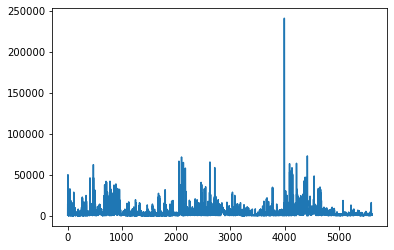

In [152]:
WV['MTT'].plot()

# Now Estimate Annual Total Traffic

In [153]:
# read the moy factor
MOY=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_MOY_Factor.csv')
MOY.head()

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
0,0,1,0.067350,seasonal_factor<=2.4
1,1,2,0.070993,seasonal_factor<=2.4
2,2,3,0.080101,seasonal_factor<=2.4
3,3,4,0.087527,seasonal_factor<=2.4
4,4,5,0.091078,seasonal_factor<=2.4


In [234]:
MOY['Criteria'].unique()

array(['seasonal_factor<=2.4', '2.4<seasonal_factor<=5',
       'seasonal_factor>5'], dtype=object)

In [245]:
# Now split the data by group
moy_g1=MOY.loc[MOY['Criteria']=='seasonal_factor<=2.4']
moy_g2=MOY.loc[MOY['Criteria']=='2.4<seasonal_factor<=5']
moy_g3=MOY.loc[MOY['Criteria']=='seasonal_factor>5']
moy_g3.head(2)

,Unnamed: 0,month,Average_Group_MOY_Factor,Criteria
24,0,1,0.021449,seasonal_factor>5
25,1,2,0.018644,seasonal_factor>5


In [155]:
# Calculate the seasonality factor and check how many sites have data to calculate it
# get June/July/August Data
dos678=DV[(DV['month']>5) &(DV['month']<9)]
dos678=dos678[['ID','year','Leg','TDV']]
dos678c=pd.DataFrame({'Average Daily Count678' : dos678.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos678c.head()

,ID,year,Leg,Average Daily Count678
0,CH32,2019.0,S,20.231538
1,Eric_Fischer1007,2016.0,E,27.327268
2,Eric_Fischer1007,2016.0,N,40.990903
3,Eric_Fischer1007,2016.0,S,40.990903
4,Eric_Fischer1028,2016.0,E,218.618147


In [158]:
# get December/January/February Data
dos12=DV.loc[DV['month']==12]
dos1=DV.loc[DV['month']==1]
dos3=DV.loc[DV['month']==2]
dos1213=pd.concat([dos12,dos1,dos3],axis=0)
dos1213=dos1213[['ID','year',"Leg",'TDV']]
dos12131=pd.DataFrame({'Average Daily Count12131' : dos1213.groupby(['ID','year','Leg'])['TDV'].mean()}).reset_index()
dos12131.head()

,ID,year,Leg,Average Daily Count12131
0,AC201648,2016.0,E,84.617767
1,AC201648,2016.0,N,13.220884
2,AC201648,2016.0,S,0.000000
3,AC201648,2016.0,W,80.210805
4,AC201663,2016.0,E,41.371608


In [160]:
seasonal_data=pd.merge(dos12131,dos678c, left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
seasonal_data['seasonal_factor']=seasonal_data['Average Daily Count678']/seasonal_data['Average Daily Count12131']
seasonal_data=seasonal_data[['ID','year','Leg','seasonal_factor']]
seasonal_data.head()

,ID,year,Leg,seasonal_factor


In [236]:
# It seems none of the sites have data to calculate the seasonality, therefore used geohrahic classification to assign the
#seasonality group. Use the closest distance to assign the seasonal group
g1=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group1.shp')
g1['group']='seasonal_factor<=2.4'
g2=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group2.shp')
g2['group']='2.4<seasonal_factor<=5'
g3=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Revised_Seasonality/Group3.shp')
g3['group']='seasonal_factor>5'
# combine all
s_g=pd.concat([g1,g2,g3],axis=0)
#s_g['group'] = s_g['group'].apply(np.int64)
s_g.head()

,Field1,ID,latitude,longitude,location,road,city,county,state,country,Average_se,geometry,group
0,0,671,37.791160,-122.459440,urban,Bay Area Ridge Trail,San Francisco,None,California,United States,1.268874,POINT (-122.45944 37.79116),seasonal_factor<=2.4
1,1,1127,37.796165,-122.419490,urban,Broadway,San Francisco,None,California,United States,1.012863,POINT (-122.41949 37.79617),seasonal_factor<=2.4
2,2,2415,37.774200,-122.436295,urban,Fell Street,San Francisco,None,California,United States,1.407406,POINT (-122.43629 37.77420),seasonal_factor<=2.4
3,3,2694,33.683254,-117.662080,urban,Torino Drive,None,Orange County,California,United States,1.359999,POINT (-117.66208 33.68325),seasonal_factor<=2.4
4,4,2695,33.672590,-117.651860,urban,Serrano Road,None,Orange County,California,United States,1.515797,POINT (-117.65186 33.67259),seasonal_factor<=2.4


In [237]:
s_g.groupby(['group'])['ID'].count()

group
2.4<seasonal_factor<=5      6
seasonal_factor<=2.4      152
seasonal_factor>5           6
Name: ID, dtype: int64

In [238]:
s_g.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [239]:
WV1 = gpd.GeoDataFrame(WV, geometry=gpd.points_from_xy(WV.Long, WV.Lat))
WV1.head()

,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,AC201611,2016,E,11,156621,37.862114,-122.253551,242.093951,34.584850,1,2016-11-01,30,1037.545505,POINT (-122.25355 37.86211),1
1,1,AC201611,2016,N,11,156618,37.862114,-122.253551,3410.934774,487.276396,1,2016-11-01,30,14618.291889,POINT (-122.25355 37.86211),1
2,2,AC201611,2016,S,11,156615,37.862114,-122.253551,3083.885825,440.555118,1,2016-11-01,30,13216.653535,POINT (-122.25355 37.86211),1
3,3,AC201611,2016,W,11,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877,143.337554,1,2016-11-01,30,4300.126617,POINT (-122.25355 37.86211),1
4,4,AC201614,2016,E,10,158585,37.867590,-122.267830,8761.823016,1251.689002,1,2016-10-01,31,38802.359070,POINT (-122.26783 37.86759),1


In [240]:
crs = {'init': 'epsg:4326'}
WV2 = gpd.GeoDataFrame(WV1, crs=crs, geometry = 'geometry')
WV2.head()

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,AC201611,2016,E,11,156621,37.862114,-122.253551,242.093951,34.584850,1,2016-11-01,30,1037.545505,POINT (-122.25355 37.86211),1
1,1,AC201611,2016,N,11,156618,37.862114,-122.253551,3410.934774,487.276396,1,2016-11-01,30,14618.291889,POINT (-122.25355 37.86211),1
2,2,AC201611,2016,S,11,156615,37.862114,-122.253551,3083.885825,440.555118,1,2016-11-01,30,13216.653535,POINT (-122.25355 37.86211),1
3,3,AC201611,2016,W,11,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877,143.337554,1,2016-11-01,30,4300.126617,POINT (-122.25355 37.86211),1
4,4,AC201614,2016,E,10,158585,37.867590,-122.267830,8761.823016,1251.689002,1,2016-10-01,31,38802.359070,POINT (-122.26783 37.86759),1


In [241]:
# project the co-ordinate
WV2_proj = WV2.to_crs(epsg=3310).reset_index()
s_g_proj = s_g.to_crs(epsg=3310).reset_index()

In [242]:
def nearest_point(point, point2):
    idx = point2.geometry.distance(point).idxmin()
    return point2.loc[idx,'group']

In [243]:
WV2_proj['group'] = WV2_proj.geometry.apply(nearest_point, point2=s_g_proj)
WV2_proj.head()

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
0,0,0,AC201611,2016,E,11,156621,37.862114,-122.253551,242.093951,34.584850,1,2016-11-01,30,1037.545505,POINT (-197977.604 -14794.719),seasonal_factor<=2.4
1,1,1,AC201611,2016,N,11,156618,37.862114,-122.253551,3410.934774,487.276396,1,2016-11-01,30,14618.291889,POINT (-197977.604 -14794.719),seasonal_factor<=2.4
2,2,2,AC201611,2016,S,11,156615,37.862114,-122.253551,3083.885825,440.555118,1,2016-11-01,30,13216.653535,POINT (-197977.604 -14794.719),seasonal_factor<=2.4
3,3,3,AC201611,2016,W,11,bearing calculation not match with TMS count,37.862114,-122.253551,1003.362877,143.337554,1,2016-11-01,30,4300.126617,POINT (-197977.604 -14794.719),seasonal_factor<=2.4
4,4,4,AC201614,2016,E,10,158585,37.867590,-122.267830,8761.823016,1251.689002,1,2016-10-01,31,38802.359070,POINT (-199217.194 -14156.285),seasonal_factor<=2.4


In [244]:
# Now split the data by group
m_g1=WV2_proj.loc[WV2_proj['group']=='seasonal_factor<=2.4']
m_g2=WV2_proj.loc[WV2_proj['group']=='2.4<seasonal_factor<=5']
m_g3=WV2_proj.loc[WV2_proj['group']=='seasonal_factor>5']
m_g3.head(2)

,level_0,index,ID,year,Leg,month,matched_seg_id,Lat,Long,TWV,AWV,day,date,days_in_month,MTT,geometry,group
3259,3259,2173,Miovision10,2018,E,12,2186,39.775318,-121.871931,296.578865,42.368409,1,2018-12-01,31,1313.420686,POINT (-160258.241 197079.205),seasonal_factor>5
3260,3260,2174,Miovision10,2018,N,12,2183,39.775318,-121.871931,173.963684,24.851955,1,2018-12-01,31,770.410601,POINT (-160258.241 197079.205),seasonal_factor>5


In [247]:
# Now apply the MOY factor to get ATT
# Apply factor to obtain daily Volume
mg1_DV=pd.merge(m_g1,moy_g1, on=['month'], how='inner')
mg1_DV['Annual_Volume']=mg1_DV['MTT']/mg1_DV['Average_Group_MOY_Factor']
mg1_DV1=pd.DataFrame({'ATT' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg2_DV=pd.merge(m_g2,moy_g2, on=['month'], how='inner')
mg2_DV['Annual_Volume']=mg2_DV['MTT']/mg2_DV['Average_Group_MOY_Factor']
mg2_DV2=pd.DataFrame({'ATT' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg3_DV=pd.merge(m_g3,moy_g3, on=['month'], how='inner')
mg3_DV['Annual_Volume']=mg3_DV['MTT']/mg3_DV['Average_Group_MOY_Factor']
mg3_DV3=pd.DataFrame({'ATT' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id','Lat','Long'])['Annual_Volume'].mean()}).reset_index()
mg3_DV3.head()

,ID,year,Leg,matched_seg_id,Lat,Long,ATT
0,Miovision10,2018,E,2186,39.775318,-121.871931,184023.109315
1,Miovision10,2018,N,2183,39.775318,-121.871931,107942.074968
2,Miovision10,2018,W,2185,39.775318,-121.871931,104905.033822
3,Miovision102,2018,E,80658,39.171286,-120.140659,54722.681320
4,Miovision102,2018,W,80632,39.171286,-120.140659,46166.923312


In [250]:
# combine these three group of estimated Annual volume together
AV=pd.concat([mg1_DV1,mg2_DV2,mg3_DV3],axis=0).reset_index()
AV.ATT = AV.ATT.round()
AV.shape

(5611, 8)

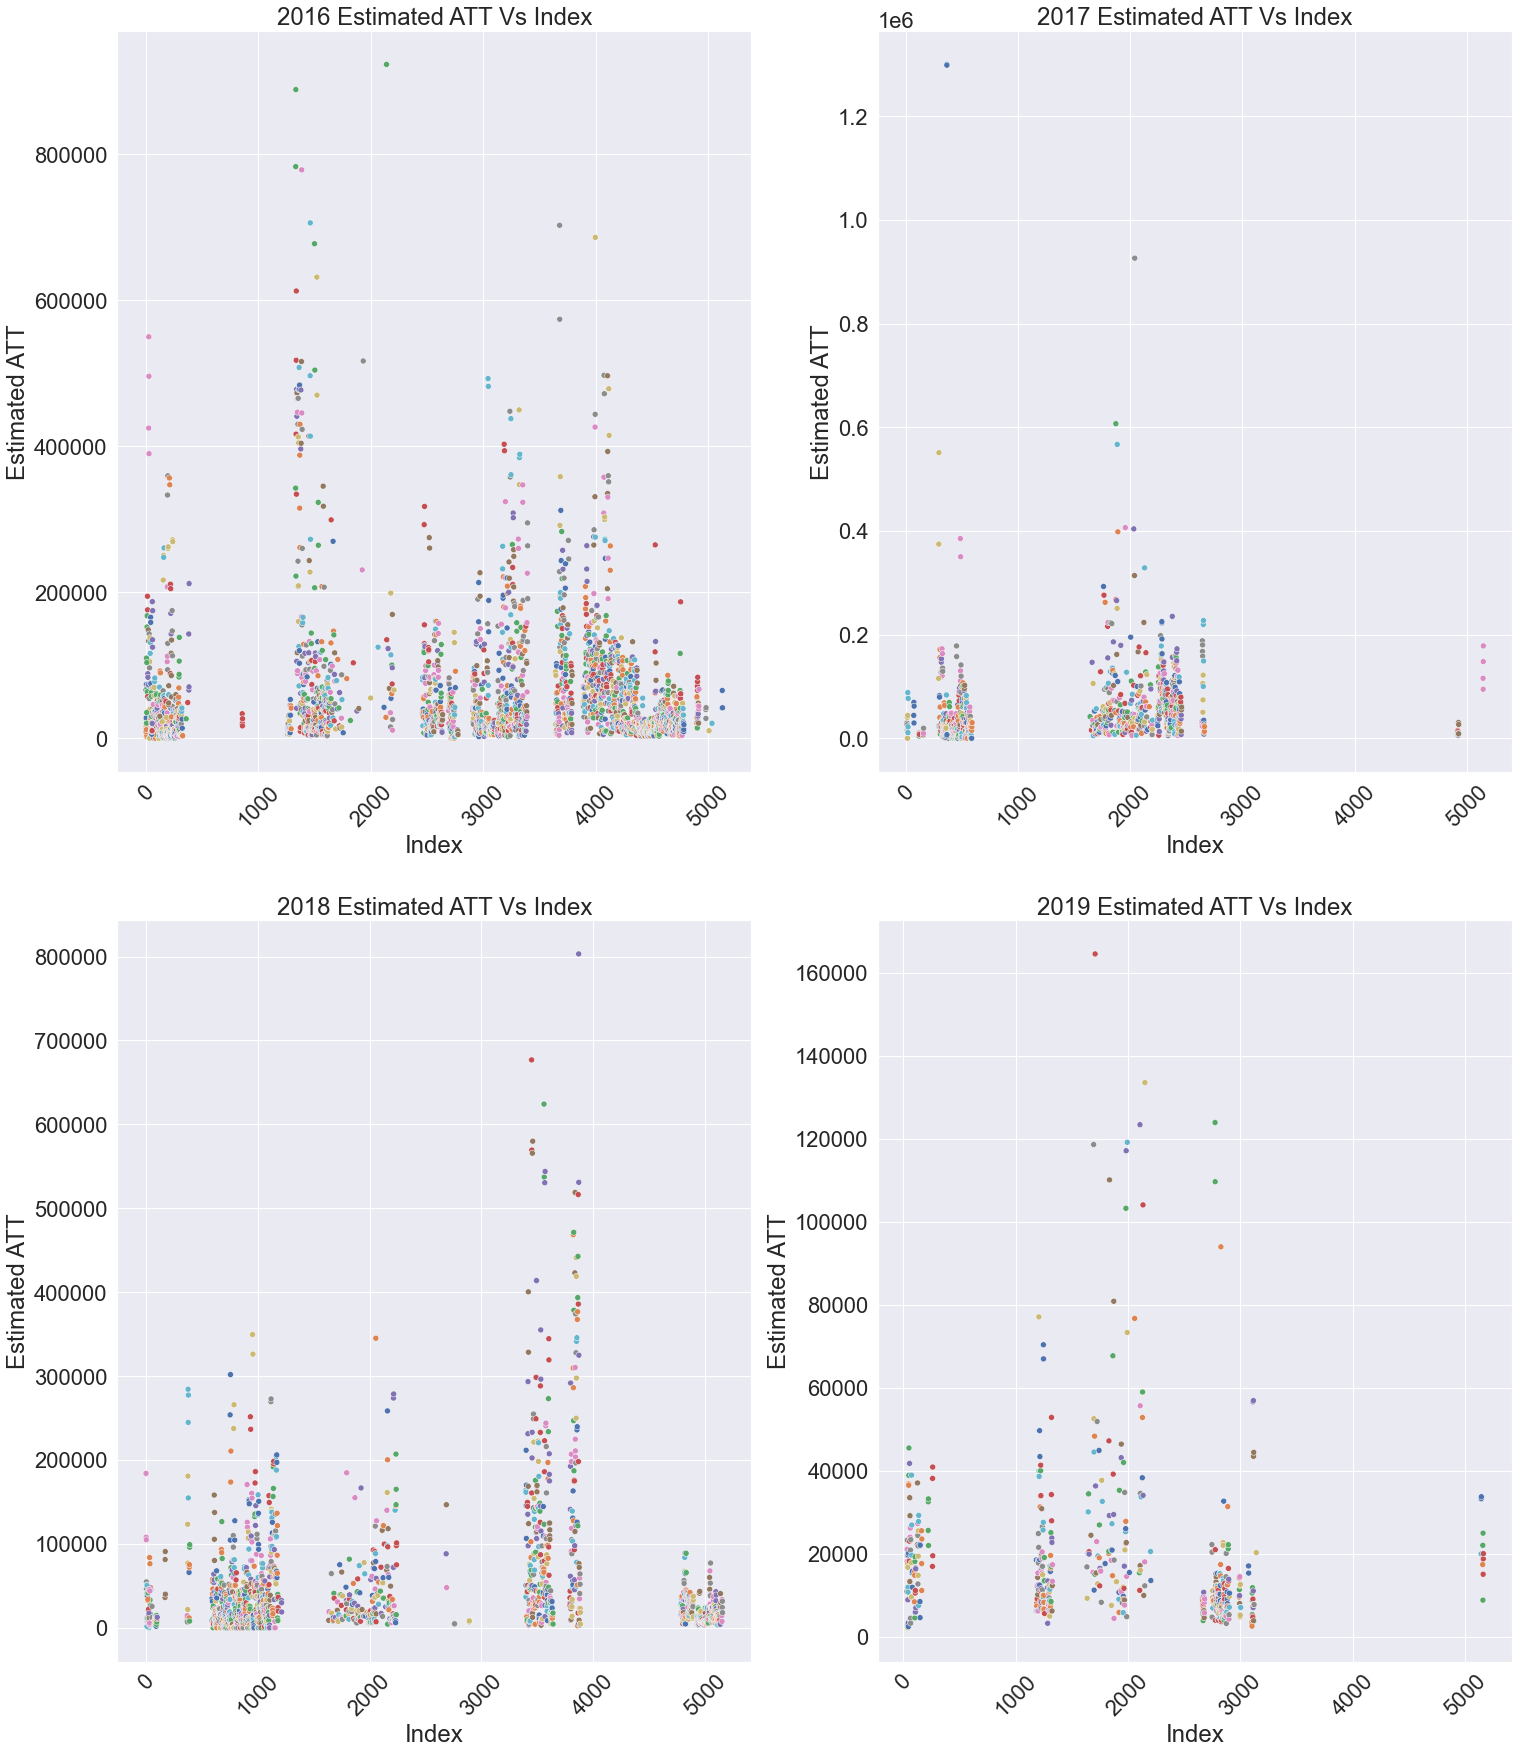

In [263]:
sns.set(rc={'figure.figsize':(25,30)})
sns.set(font_scale=2.0)
import seaborn as sns
d16=AV.loc[AV['year']==2016]
d17=AV.loc[AV['year']==2017]
d18=AV.loc[AV['year']==2018]
d19=AV.loc[AV['year']==2019]
fig, ax = plt.subplots(2,2)    
ax1 = sns.scatterplot(x=d16['index'],y=d16['ATT'],hue=d16['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,0]) 
plt.xticks(rotation = 'vertical')
ax2 = sns.scatterplot(x=d17['index'],y=d17['ATT'],hue=d17['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[0,1]) 
plt.xticks(rotation = 'vertical')
ax3 = sns.scatterplot(x=d18['index'],y=d18['ATT'],hue=d18['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,0])
plt.xticks(rotation = 'vertical')
ax4 = sns.scatterplot(x=d19['index'],y=d19['ATT'],hue=d19['ID'],palette="deep",
                       markers=True,marker="o",ax=ax[1,1]) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax1.title.set_text('2016 Estimated ATT Vs Index')
ax2.title.set_text('2017 Estimated ATT Vs Index')
ax3.title.set_text('2018 Estimated ATT Vs Index')
ax4.title.set_text('2019 Estimated ATT Vs Index')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax1.set_ylabel('Estimated ATT' )
ax1.set_xlabel('Index')
ax2.set_ylabel('Estimated ATT' )
ax2.set_xlabel('Index')
ax3.set_ylabel('Estimated ATT' )
ax3.set_xlabel('Index')
ax4.set_ylabel('Estimated ATT' )
ax4.set_xlabel('Index')
plt.show()

In [254]:
AV.groupby(['year'])['Leg'].count()

year
2016    2674
2017     855
2018    1574
2019     508
Name: Leg, dtype: int64

In [266]:
AV.groupby(['year','Leg'])['ATT'].describe()

count          mean            std     min       25%      50%  \
year Leg                                                                      
2016 E        641.0  62736.120125   93793.321567     0.0  14648.00  29275.0   
     N        652.0  63812.909509   92632.534601     0.0  13793.00  34300.5   
     S        635.0  64345.275591   91123.133286     0.0  13178.00  36255.0   
     W        614.0  63423.967427   92693.672545     0.0  13306.50  28968.5   
     unknown  132.0  95253.196970   91490.250257  5627.0  41870.75  78980.5   
2017 E        198.0  62472.282828   86330.673877     0.0  17659.75  37480.5   
     N        232.0  60969.137931  105794.878657     0.0  14793.25  33946.0   
     S        217.0  65274.511521  113921.827381     0.0  12713.00  33388.0   
     W        204.0  60391.799020   61769.999510     0.0  20395.50  41778.0   
     unknown    4.0  10512.750000    6181.470719  6095.0   6583.25   8240.5   
2018 E        393.0  60050.765903   88284.335310     0.0  13415.00  30857.0   
     N        404.0  57726.732673   87596.952012     0.0  10717.00  25626.0   
     S        402.0  51938.271144   74327.743705     0.0  10839.75  24189.0   
     W        372.0  59461.413978   88046.646784     0.0  12224.00  29956.5   
     unknown    3.0  32307.666667   24489.582200  4060.0  24677.50  45295.0   
2019 E        132.0  21312.492424   22256.030432  3499.0   8443.25  14466.0   
     N        112.0  16477.535714   19090.917143  2114.0   6993.00  10384.5   
     S        118.0  18326.788136   20231.269136  2398.0   7155.50  12227.5   
     W        130.0  20411.192308   20961.213533  3172.0   7992.25  13453.5   
     unknown   16.0  10625.937500    6706.869905  4228.0   6658.75   9615.0   

                    75%        max  
year Leg                            
2016 E         63114.00   677248.0  
     N         78530.00   782867.0  
     S         81011.50   922860.0  
     W         67584.25   516683.0  
     unknown  119741.50   685950.0  
2017 E         85394.50   926231.0  
     N         73608.50  1299972.0  
     S         79441.00  1298527.0  
     W         80898.00   406392.0  
     unknown   12170.00    19475.0  
2018 E         66439.00   676805.0  
     N         61799.00   803095.0  
     S         52918.00   530924.0  
     W         65209.75   579932.0  
     unknown   46431.50    47568.0  
2019 E         24068.25   133539.0  
     N         18456.50   123917.0  
     S         20030.50   123396.0  
     W         23272.50   164556.0  
     unknown   11963.25    32643.0

In [255]:
AV.groupby(['year'])['ID'].count()

year
2016    2674
2017     855
2018    1574
2019     508
Name: ID, dtype: int64

In [256]:
AV.groupby(['year'])['ID'].nunique()

year
2016    895
2017    401
2018    553
2019    254
Name: ID, dtype: int64

In [257]:
AV['ID'].nunique()

2103

In [264]:
# Save the estimation
AV.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Estimated_SC_ATT.csv',index=False)